## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [10]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [11]:
train, test = keras.datasets.cifar10.load_data()

In [12]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [13]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
EARLY_STOP = [5, 10, 25]

In [16]:
"""
# 載入 Callbacks, 並將 monitor 設定為監控 val_accuracy
"""
from keras.callbacks import EarlyStopping

results = {}
"""
使用迴圈，建立不同 Batch Szie 的模型並訓練
"""
for es in EARLY_STOP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Early Stop = %.6f" % (es))
    earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=es, 
                          verbose=1
                          )    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "es-%s" % str(es)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Early Stop = 5.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3

50000/50000 [==============================] - 13s 262us/step - loss: 1.4390 - accuracy: 0.4925 - val_loss: 1.5892 - val_accuracy: 0.4384
Epoch 7/50
50000/50000 [==============================] - 15s 294us/step - loss: 1.4003 - accuracy: 0.5079 - val_loss: 1.5485 - val_accuracy: 0.4560
Epoch 8/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.3643 - accuracy: 0.5198 - val_loss: 1.5241 - val_accuracy: 0.4605
Epoch 9/50
50000/50000 [==============================] - 14s 281us/step - loss: 1.3308 - accuracy: 0.5352 - val_loss: 1.5026 - val_accuracy: 0.4632
Epoch 10/50
50000/50000 [==============================] - 13s 253us/step - loss: 1.3012 - accuracy: 0.5454 - val_loss: 1.4953 - val_accuracy: 0.4698
Epoch 11/50
50000/50000 [==============================] - 13s 258us/step - loss: 1.2731 - accuracy: 0.5563 - val_loss: 1.4925 - val_accuracy: 0.4722
Epoch 12/50
50000/50000 [==============================] - 18s 357us/step - loss: 1.2478 - accuracy: 0.5655 - val_l

50000/50000 [==============================] - 16s 314us/step - loss: 2.2199 - accuracy: 0.2783 - val_loss: 2.1408 - val_accuracy: 0.2088
Epoch 2/50
50000/50000 [==============================] - 12s 247us/step - loss: 1.7399 - accuracy: 0.3975 - val_loss: 1.9618 - val_accuracy: 0.2880
Epoch 3/50
50000/50000 [==============================] - 13s 256us/step - loss: 1.6108 - accuracy: 0.4379 - val_loss: 1.8185 - val_accuracy: 0.3666
Epoch 4/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.5357 - accuracy: 0.4642 - val_loss: 1.6944 - val_accuracy: 0.4130
Epoch 5/50
50000/50000 [==============================] - 14s 283us/step - loss: 1.4793 - accuracy: 0.4868 - val_loss: 1.6260 - val_accuracy: 0.4284
Epoch 6/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.4345 - accuracy: 0.5008 - val_loss: 1.5877 - val_accuracy: 0.4369
Epoch 7/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.3966 - accuracy: 0.5127 - val_loss

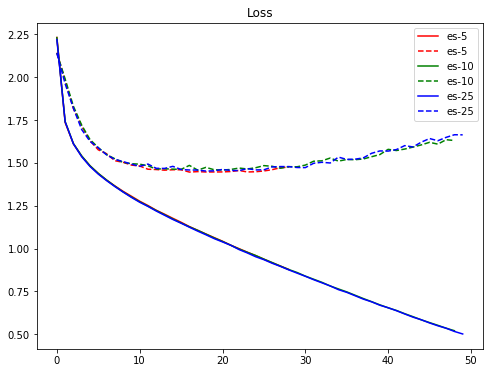

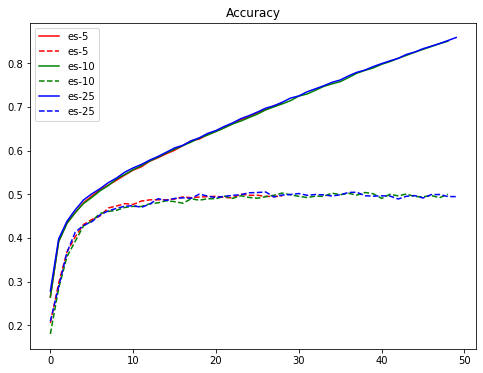

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
